In [1]:
from data.download import download

# Get daily grayscale rainfall data (https://neo.gsfc.nasa.gov/archive/gs/GPM_3IMERGDL/)
iamges_dir = download()

In [2]:
import torch
from torch import nn


class ConvRNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, kernal_size_, padding_):
        super(ConvRNN, self).__init__()
        self.hidden_channels = hidden_channels
        self.conv1 = nn.Conv2d(in_channels + hidden_channels, hidden_channels, kernel_size=kernal_size_, padding=padding_)
        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels, kernel_size=kernal_size_, padding=padding_)
        self.conv3 = nn.Conv2d(hidden_channels, in_channels, kernel_size=kernal_size_, padding=padding_)

    def forward(self, in_tensor, h):
        h = torch.cat((in_tensor, h), dim=1)
        h = torch.relu(self.conv1(h))
        h = torch.relu(self.conv2(h))
        return self.conv3(h), h

    def init_hidden(self, batch_size, img_size):
        return torch.zeros(batch_size, self.hidden_channels, *img_size)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob

def rolling_batch(files_list, seq_len, batch_size):
    
    # Load with plt.imread
    batch_images = np.array([plt.imread(files_list[i]) for i in range(start, stop)])

    # TEMPORARILY crop images here - will be done in a preprocessing step once effects on model are clear
    image_size = batch_images.shape[-2:]
    batch_images = batch_images[:, :image_size[0]//2, :image_size[1]//2]
    image_size = batch_images.shape[-2:]

    # Explicit single gs channel
    batch_images = batch_images.reshape(len(batch_images), 1, *image_size)

    # Organize into (batch_size, seq_len, channels=1, *image_size) (X and y)
    batch_size = stop - start - seq_len
    X = np.array([
                    batch_images[seq_n : seq_n + seq_len]
                    for seq_n in range(batch_size)
                    ])
    y = np.array([
                    batch_images[seq_n + seq_len]
                    for seq_n in range(batch_size)
                    ])

    return torch.from_numpy(X), torch.from_numpy(y)


# Test rolling_batch
n_images_test = 50
test_image_files = sorted(glob(iamges_dir + '/*.PNG'))[-n_images_test:]
X, y = rolling_batch(test_image_files, 1, 5, 2)
assert X.shape == (2, 2, 1, 900, 1800), X.shape
assert y.shape == (2, 1, 900, 1800), y.shape

In [4]:
def predict(model, X, seq_len):
    """ For a single batch """

    hidden = model.init_hidden(X.shape[0], X.shape[-2:])

    for step in range(seq_len - 1):
        _, hidden = model(X[:,step], hidden)

    pred, _ = model(X[:, -1], hidden)
    return pred

CPU times: user 42.1 s, sys: 34 s, total: 1min 16s
Wall time: 40.9 s


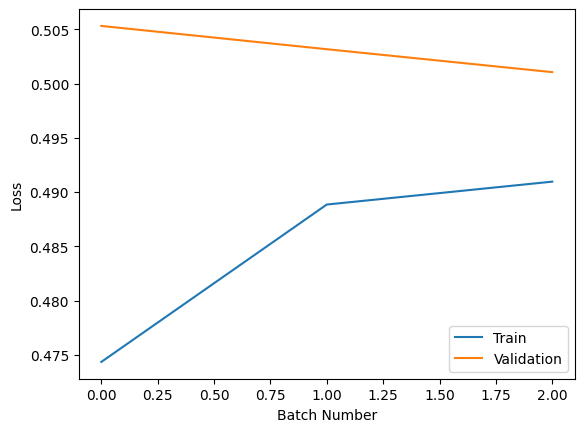

In [5]:
from math import ceil

def train(model, files_list, train_frac, val_frac, seq_len, batch_size):

    n_images = len(files_list)
    train_n = int(train_frac * n_images)
    images_per_batch = seq_len + batch_size
    n_batches = train_n / images_per_batch

    model.train()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())
    train_losses = []
    
    if val_frac != 0:
        X_val, y_val = rolling_batch(files_list, train_n, int((train_frac + val_frac)*n_images), seq_len)
        val_losses = []

    for batch_n in range(int(n_batches)):
        
        # Use smaller final batch if needed
        # Use range(ceil(n_batches)) when correcting this
        # if batch_n == ceil(n_batches):
        #    batch_size = train_n - int(n_batches) * images_per_batch - seq_len
        #    print(batch_size) # needs to be passes (and used) in rolling_batch
        
        # Make training batch
        start_batch_ind = batch_n * images_per_batch
        stop_batch_ind = (batch_n + 1) * images_per_batch
        X_train, y_train = rolling_batch(files_list, start_batch_ind, stop_batch_ind, seq_len)

        # Predictions and loss on training batch
        y_pred = predict(model, X_train, seq_len)
        train_loss = criterion(y_pred, y_train)
        train_losses.append(train_loss.item())
        del X_train, y_train, y_pred, train_loss

        # Update model
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # Validation if not refitting
        if val_frac != 0:
            model.eval()
            y_pred = predict(model, X_val, seq_len)
            val_loss = criterion(y_pred, y_val)
            val_losses.append(val_loss.item())
            del X_val, y_val, y_pred, val_loss
            model.train()

    return train_losses, val_losses

# Test train function
crnn = ConvRNN(in_channels=1, hidden_channels=2, kernal_size_=3, padding_=1)
%time train_loss, val_loss = train(crnn, test_image_files, 0.6, 0.2, 5, 5)
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.legend()
plt.xlabel('Batch Number')
plt.ylabel('Loss');

### Real training

In [ ]:
n_images = 500
image_files = sorted(glob(iamges_dir + '/*.PNG'))[-n_images:]

crnn = ConvRNN(in_channels=1, hidden_channels=2, kernal_size_=3, padding_=1)
%time train_loss, val_loss = train(crnn, image_files, 0.6, 0.2, 5, 5)
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.legend()
plt.xlabel('Batch Number')
plt.ylabel('Loss');